Import the necessary libraries

In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import classification_report, accuracy_score

Load the dataset

In [ ]:
# Load the dataset
data = pd.read_csv('Tablet_press_data.csv')

print(data.head(10))

    Pressure  Temperature       Speed  Vibration   Humidity  \
0  62.512145    28.220422  758.141650   0.292994  49.799312   
1  69.941139    32.452611  590.881799   9.463787  48.547032   
2  60.912694    23.096572  741.749043   5.567093  58.904469   
3  76.515107    21.693767  680.608030   8.567299  61.665603   
4  82.498197    30.125321  669.042205   3.645664  46.897832   
5  58.826402    33.449210  718.949944   5.924830  64.884243   
6  86.409438    30.928606  775.330230   8.425345  30.455587   
7  53.852914    28.362896  640.642282   4.753591  59.968687   
8  94.694629    34.154427  730.366800   9.992073  38.395714   
9  90.328057    31.434920  934.824842   3.506427  55.201383   

   Maintenance_Cycles  Failure  
0                  13        0  
1                  10        1  
2                   6        1  
3                  12        1  
4                  13        0  
5                   8        1  
6                  16        1  
7                  10        0  
8        

Check for missing values

In [ ]:
# Check for missing values
print("Missing Values:")
print(data.isnull().sum())


Missing Values:
Pressure              0
Temperature           0
Speed                 0
Vibration             0
Humidity              0
Maintenance_Cycles    0
Failure               0
dtype: int64


Check for outliers


Outlier Detection (IQR Method):
Pressure: 0 outliers


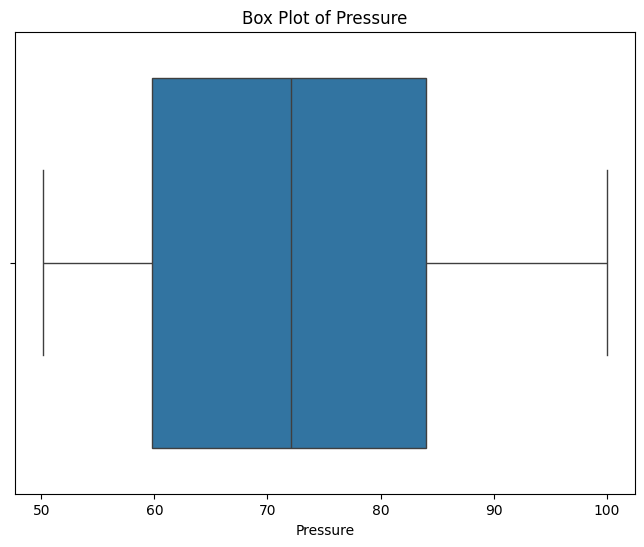

Temperature: 0 outliers


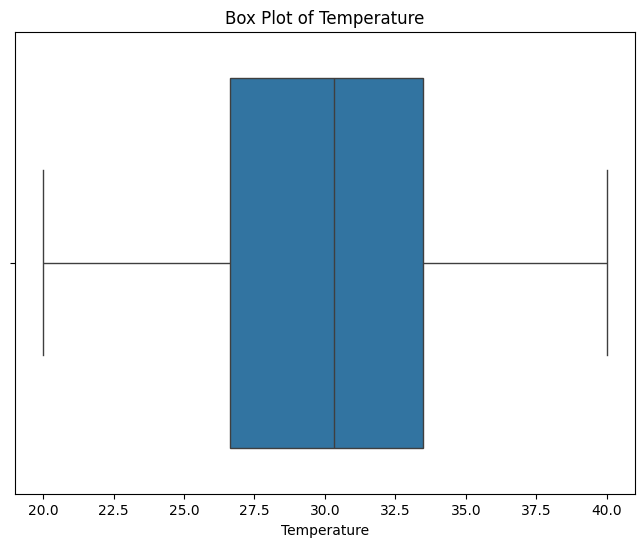

Speed: 0 outliers


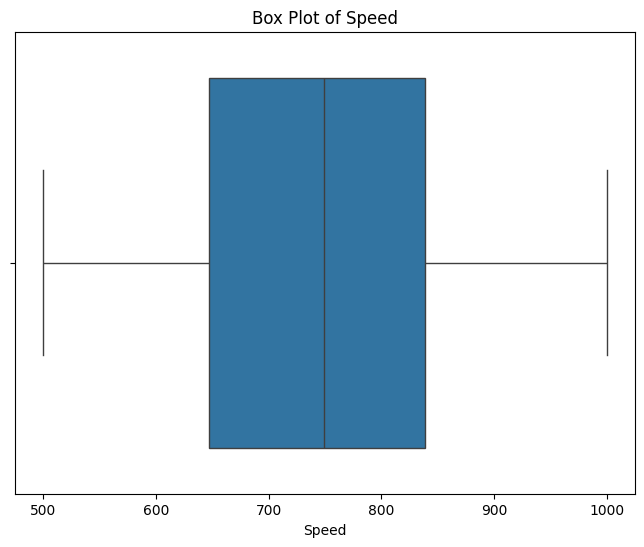

Vibration: 0 outliers


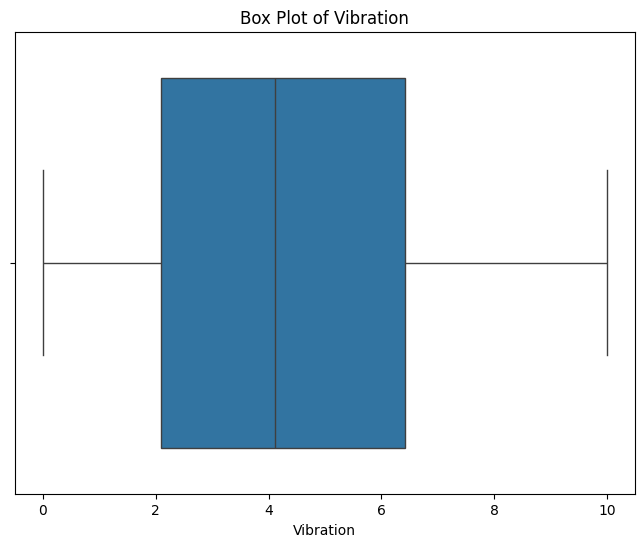

Humidity: 0 outliers


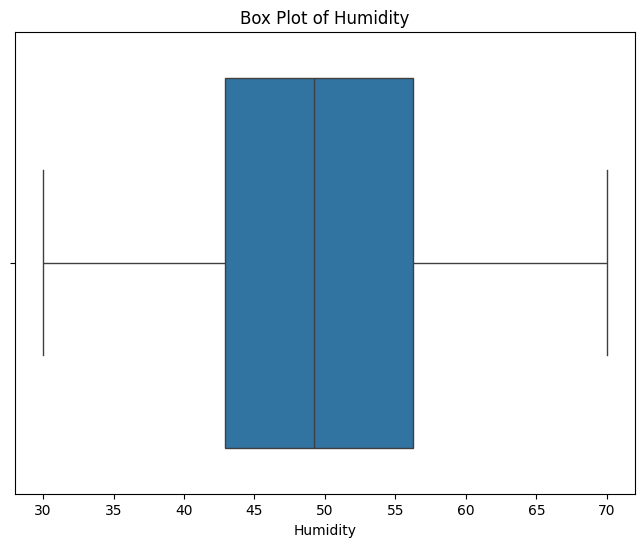

Maintenance_Cycles: 0 outliers


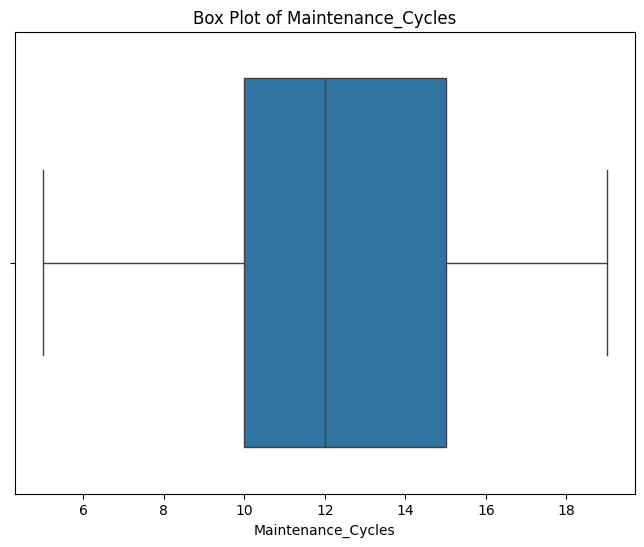

Failure: 0 outliers


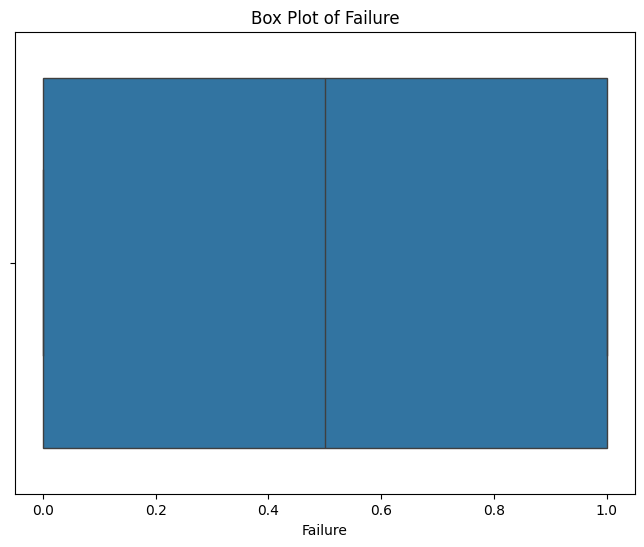

In [ ]:
# Check for outliers using the IQR method
print("\nOutlier Detection (IQR Method):")
for column in data.select_dtypes(include=[np.number]).columns:
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    print(f"{column}: {len(outliers)} outliers")

    # Plot boxplot for each feature
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=data[column])
    plt.title(f'Box Plot of {column}')
    plt.show()

Split the dataset into features and target

In [ ]:

# Split the dataset into features (X) and target (y)
X = data.drop(columns=['Failure'])
y = data['Failure']


Standard scaling the features

In [ ]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Split the data into training and testing sets

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


Create the voting classifier

In [ ]:
svm1 = SVC(kernel='linear', C=1)
svm2 = SVC(kernel='rbf', C=1, gamma='scale')
svm3 = SVC(kernel='poly', C=1, degree=3)

# Create a Voting Classifier with hard voting (majority voting)
voting_clf = VotingClassifier(estimators=[
    ('svm1', svm1),
    ('svm2', svm2),
    ('svm3', svm3)
], voting='hard')

Perform the grid search cross validation and find the best hyperparameters

In [ ]:
# Define the parameter grid for GridSearchCV to tune SVC hyperparameters
param_grid = {
    'svm1__C': [0.1, 1, 10],
    'svm2__C': [0.1, 1, 10],
    'svm2__gamma': ['scale', 'auto'],
    'svm3__C': [0.1, 1, 10],
    'svm3__degree': [2, 3, 4]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(voting_clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=VotingClassifier(estimators=[('svm1',
                                                     SVC(C=1, kernel='linear')),
                                                    ('svm2', SVC(C=1)),
                                                    ('svm3',
                                                     SVC(C=1, kernel='poly'))]),
             n_jobs=-1,
             param_grid={'svm1__C': [0.1, 1, 10], 'svm2__C': [0.1, 1, 10],
                         'svm2__gamma': ['scale', 'auto'],
                         'svm3__C': [0.1, 1, 10], 'svm3__degree': [2, 3, 4]},
             scoring='accuracy')

Use the best model and predict the test dataset and evaluate performance

In [ ]:
# Get the best model from grid search
best_voting_svm = grid_search.best_estimator_
best_cv_score = grid_search.best_score_

# Evaluate the best model on the test set
y_pred = best_voting_svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred)

# Output the results
print(f"Accuracy on test set: {accuracy}")
print(f"Cross-validation score of the best model during GridSearchCV: {best_cv_score}")
print(f"Classification report:\n{classification_report_output}")

Accuracy on test set: 0.9724770642201835
Cross-validation score of the best model during GridSearchCV: 0.9823020579002442
Classification report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       382
           1       1.00      0.94      0.97       381

    accuracy                           0.97       763
   macro avg       0.97      0.97      0.97       763
weighted avg       0.97      0.97      0.97       763

